# remaking CNN for sequence->epi part in pytorch

In [1]:
# it's relatively straightforward, can utilize the basic script, first we have to figure out a convolution is actually doing
import torch
import torch.nn as nn

#make a simple net that is 1 input channel 1 output channel and 1d conv

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv1d(1, 1, 3, bias=False)
        self.conv.weight.data.fill_(1)
        self.conv.weight.data[0, 0, 1] = 2
        self.conv.weight.data[0, 0, 2] = 3

    def forward(self, x):
        return self.conv(x)
#print all the names and weights of the model
model = Net()
for name, param in model.named_parameters():
    print(name, param.data)

conv.weight tensor([[[1., 2., 3.]]])


In [4]:
#the kernel is 1,2,3
model.conv.weight.data.shape #it's 1x1x3, which corresponds to 1 output channel, 1 input channel, and 3 kernel size

torch.Size([1, 1, 3])

In [5]:
temp = nn.Conv1d(2,1,3, bias=False) #order is input channels, output channels, kernel size
temp.weight.data.shape #so it's now output channel, input channel, kernel size

torch.Size([1, 2, 3])

In [6]:
#let's make some basic data
x = torch.tensor([1,2,3,4,5,6], dtype=torch.float32).view(1,1,-1)
x.shape #it's 1x1x6 which is 1 batch, 1 channel, 6 length
#the output will obviously be 1 batch, 1 channel, 6 length (assuming we do same padding)

torch.Size([1, 1, 6])

In [14]:
temp = nn.Conv1d(1,1,3, bias=False, padding='same')
temp.weight.data[0,0,0] = 1
temp.weight.data[0,0,1] = 2
temp.weight.data[0,0,2] = 3
print(temp.weight.data)
print(x)
temp(x).shape #now we see it's 1x1x6

tensor([[[1., 2., 3.]]])
tensor([[[1., 2., 3., 4., 5., 6.]]])


torch.Size([1, 1, 6])

In [13]:
temp(x) #so with same padding, adds 1 0 on the front, and 1 0 on the back, and then does the convolution
#this means the first element is obviously 8, the second element is 14 etc. it does indeed check out

tensor([[[ 8., 14., 20., 26., 32., 17.]]], grad_fn=<ConvolutionBackward0>)

In [23]:
#now let's try this with more channels to see what happens
#so let's do same input but more output channels
temp = nn.Conv1d(1,2,3, bias=False, padding='same')
print(temp.weight.data.shape)
temp.weight.data[0,0,:] = torch.tensor([1,2,3])
temp.weight.data[1,0,:] = torch.tensor([4,5,6])
print(temp.weight.data)
print(x)

torch.Size([2, 1, 3])
tensor([[[1., 2., 3.]],

        [[4., 5., 6.]]])
tensor([[[1., 2., 3., 4., 5., 6.]]])


In [20]:
print(temp(x).shape, temp(x), sep='\n') #output channel 1 is the same, channel 2 is just like applying that second one!
#so this shows that we basically do 2 convolutions with 2 separate filters, and then stack them together

torch.Size([1, 2, 6])
tensor([[[ 8., 14., 20., 26., 32., 17.],
         [17., 32., 47., 62., 77., 50.]]], grad_fn=<ConvolutionBackward0>)


In [27]:
#now the question is how does it work with bias
temp = nn.Conv1d(1,2,3, padding='same')
temp.weight.data[0,0,:] = torch.tensor([1,2,3])
temp.weight.data[1,0,:] = torch.tensor([4,5,6])
print(temp.bias.data) #just 2 elements, each channel gets own bias
temp.bias.data[0] = 1
temp.bias.data[1] = 10
print(temp(x)) #so adds bias 1 to all the terms of the channel output 1, and adds bias 2 to all the same output channels
#so it it completely identical to just doing n independent convolutions and then stacking them together along the channel axis

tensor([ 0.1035, -0.1143])
tensor([[[ 9., 15., 21., 27., 33., 18.],
         [27., 42., 57., 72., 87., 60.]]], grad_fn=<ConvolutionBackward0>)


In [28]:
#now we see how it works with 2 input channels to 1 output channel
x = torch.tensor([1,2,3,4,5,6], dtype=torch.float32).view(1,2,-1)
temp = nn.Conv1d(2,1,3, bias=False, padding='same')
temp.weight.data[0,0,:] = torch.tensor([1,2,3])
temp.weight.data[0,1,:] = torch.tensor([4,5,6])
print(temp.weight.data)
print(x)
#so now what happens is we create a kernel that is the same size as the channels, but it's only 1 kernel, and movement is only along the length dimension
#if we have multiple kernels then multiple channels. And what happens is we dot over this full matrix now

tensor([[[1., 2., 3.],
         [4., 5., 6.]]])
tensor([[[1., 2., 3.],
         [4., 5., 6.]]])


In [33]:
temp(x) #element 0 is 1*2+3*2+4*5+5*6 which is indeed 58 as the first term is!!
#so the key here is have to do dot of everything
#can think of this as individual convolutions along each input channel, and then summing them up
#here there's only 1 bias tho

tensor([[[58., 91., 58.]]], grad_fn=<ConvolutionBackward0>)

In [34]:
temp = nn.Conv1d(2,1,3, bias=True, padding='same')
temp.bias.data.shape #only 1 bias added to the singular output channel!!

torch.Size([1])

## summary

When dealing with multiple input channels, you can think of the convolution operation as applying independent kernels to each input channel and then summing the results to compute the final output for each output channel.

the output of a convolution with n output channels is still equivalent to applying n independent convolutions (each with its own kernel and bias) and then concatenating the results along the channel dimension.

# now we make the convolutions in pytorch

```console
X_in = Input(shape=(100000,F))

x = layers.Conv1D(256, 21, activation='relu', padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(X_in)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(2)(x)

x = Dropout(dropout_rate)(x)
x = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(2)(x)

x = Dropout(dropout_rate)(x)
x = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(5)(x)

x = Dropout(dropout_rate)(x)
x = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(5)(x)

x = Dropout(dropout_rate)(x)
x = layers.Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(x)
h = layers.BatchNormalization()(x)
x = h

for i in range(1,1+6):
    x = Dropout(dropout_rate)(x)
    x = layers.Conv1D(64, 3, activation='relu', dilation_rate=2**i, padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(x) + x
    x = layers.BatchNormalization()(x)

mu_h3k4me3 = layers.Conv1D(1, 5, activation='exponential', padding='same')(x)
mu_h3k4me3 = layers.Reshape([1000])(mu_h3k4me3)

mu_h3k27ac = layers.Conv1D(1, 5, activation='exponential', padding='same')(x)
mu_h3k27ac = layers.Reshape([1000])(mu_h3k27ac)

mu_dnase = layers.Conv1D(1, 5, activation='exponential', padding='same')(x)
mu_dnase = layers.Reshape([1000])(mu_dnase)
```

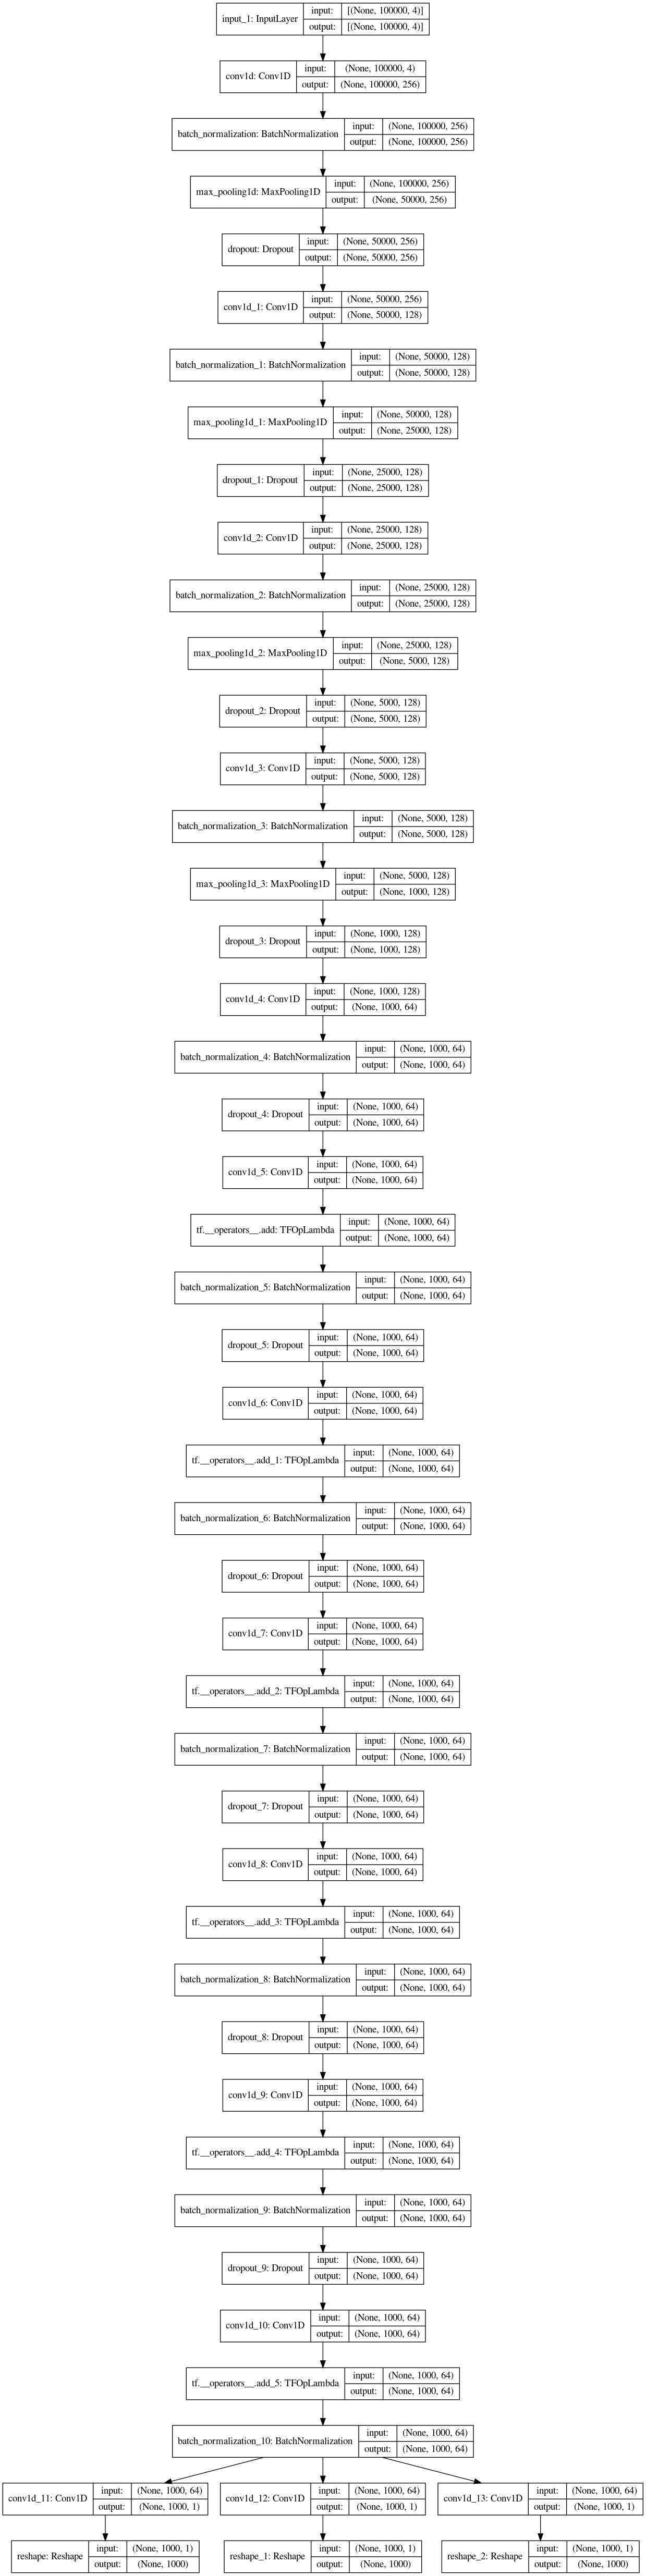

In [37]:
#that's the basics of it, so first let's copy that idea
#first this line
#x = layers.Conv1D(256, 21, activation='relu', padding='same', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))(X_in)
#this tells us that we have 256 filters which is output channel size, then we have kernel size of 21, do relu activation, same padding and l2 regularization for weight and bias
#we can easily do this

dp_rate = 0.5

input_data = torch.rand((1,4,100_000)) #length is last axis in pytorch, 4 is channel num
temp = nn.Conv1d(4,256,21, bias=True, padding='same')
out1 = temp(input_data)
print(out1.shape)
#now batch norm then max pooling
out1 = nn.BatchNorm1d(256)(out1) #takes in num channels
out1 = nn.MaxPool1d(2)(out1)
print(out1.shape)

#and now dropout
out1 = nn.Dropout(dp_rate)(out1)

#now another set of convolutions
#we repeat this for a while until we get to dilated convs

torch.Size([1, 256, 100000])
torch.Size([1, 256, 50000])


In [40]:
#by the time we are at dilated convs our data is different
x = torch.rand(1,64,1000)
#now we do a dilated conv then add the old value, it's for leakage...
#now all else is the same except we do dilated convs
temp = nn.Conv1d(64,64,3, dilation=2, padding='same')
out1 = temp(x)+x
out1.shape #keeps the same shape so can add just fine

torch.Size([1, 64, 1000])

In [41]:
#and then we have the final alyers where we split apart after the dilated convs
x = torch.rand(1,64,1000)
conv1 = nn.Conv1d(64, 1, 5, padding='same')
conv1(x).shape #so we have 1 output channel, 5 kernel size, and same padding, and then becomes 1000, and do 3 separate convs, relatively straightforward

torch.Size([1, 1, 1000])

In [57]:
#now let's make it a class

class GraphRegConvNet(nn.Module):
    def __init__(self, input_size = 100_000, dp_rate=0.5, return_hidden=False):
        super(GraphRegConvNet, self).__init__()
        
        self.input_size = input_size
        self.dp_rate = dp_rate
        self.return_hidden = return_hidden
        
        self.conv1 = nn.Conv1d(4,256,21, bias=True, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.mp1 = nn.MaxPool1d(2)
        self.dp1 = nn.Dropout(dp_rate)
        
        self.conv2 = nn.Conv1d(256,128,3, bias=True, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.mp2 = nn.MaxPool1d(2)
        self.dp2 = nn.Dropout(dp_rate)

        self.conv3 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.mp3 = nn.MaxPool1d(5)
        self.dp3 = nn.Dropout(dp_rate)
        
        self.conv4 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn4 = nn.BatchNorm1d(128)
        self.mp4 = nn.MaxPool1d(5)
        self.dp4 = nn.Dropout(dp_rate)
        
        self.conv5 = nn.Conv1d(128,64,3, bias=True, padding='same')
        self.bn5 = nn.BatchNorm1d(64)
        self.dp5 = nn.Dropout(dp_rate)
        
        #dilated convs
        for i in range(1,7):
            self.add_module(f'conv6_{i}', nn.Conv1d(64,64,3, dilation=2**i, padding='same'))
            self.add_module(f'bn6_{i}', nn.BatchNorm1d(64))
            self.add_module(f'dp6_{i}', nn.Dropout(dp_rate))
        self.dp6_6 = nn.Dropout(0) #there's no final dropout, so remove it
            
        self.conv_me3 = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_27ac = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_dnase = nn.Conv1d(64, 1, 5, padding='same')
        
    def forward(self, x):
        x = self.conv1(x).relu()
        x = self.bn1(x)
        x = self.mp1(x)
        x = self.dp1(x)
        
        x = self.conv2(x).relu()
        x = self.bn2(x)
        x = self.mp2(x)
        x = self.dp2(x)
        
        x = self.conv3(x).relu()
        x = self.bn3(x)
        x = self.mp3(x)
        x = self.dp3(x)
        
        x = self.conv4(x).relu()
        x = self.bn4(x)
        x = self.mp4(x)
        x = self.dp4(x)
        
        x = self.conv5(x).relu()
        h = self.bn5(x)
        x = h
        x = self.dp5(x)
        
        for i in range(1,7):
            x = self._modules[f'conv6_{i}'](x).relu() + x
            x = self._modules[f'bn6_{i}'](x)
            x = self._modules[f'dp6_{i}'](x)
            
        out_me3 = self.conv_me3(x).exp().view(-1,self.input_size//100)
        out_27ac = self.conv_27ac(x).exp().view(-1,self.input_size//100)
        out_dnase = self.conv_dnase(x).exp().view(-1,self.input_size//100)

        if self.return_hidden:
            return out_me3, out_27ac, out_dnase, h
        else:
            return out_me3, out_27ac, out_dnase
    
#test it with an input
model = GraphRegConvNet()
x = torch.rand(1,4,100_000)
out_me3, out_27ac, out_dnase = model(x)
print(out_me3.shape, out_27ac.shape, out_dnase.shape) #ok the output sizes do indeed look correct!!

torch.Size([1, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [45]:
#let's print the number of parameters
model = GraphRegConvNet()
num_params = sum(p.numel() for p in model.parameters())
print(num_params) #so it's 320k which is exactly how many tensorflow has, so promising??

320643


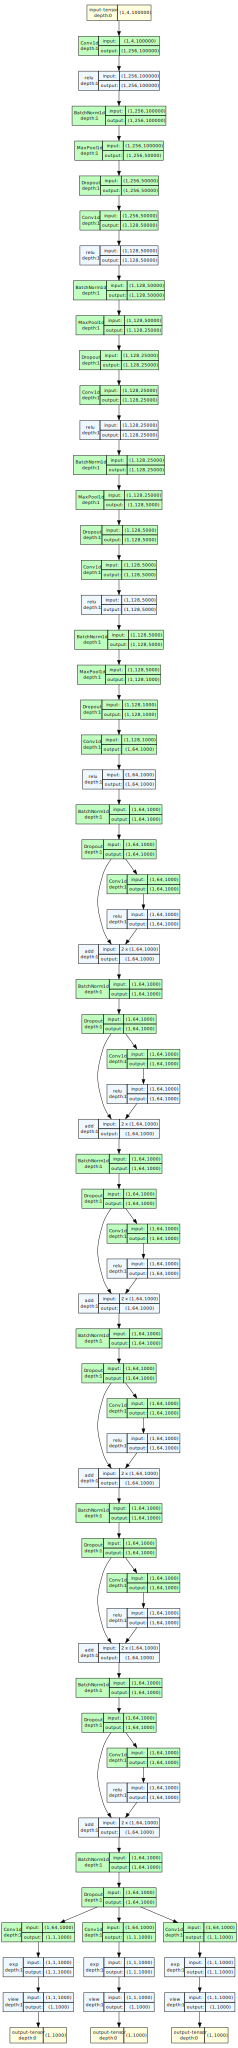

In [58]:
#let's now use torchview to view the model
from torchview import draw_graph
model_graph = draw_graph(model, x)
model_graph.visual_graph


In [59]:
#huh that does indeed seem correct! Let's manually compare the images to make sure it is!!
#manually went through, only difference is we have an additional dropout, so I forced that to be 1
model.dp6_6 #yup that's what we expect

Dropout(p=0, inplace=False)

In [60]:
a = torch.rand(1,64,1000)
b = model.dp6_6(a)
(a==b).all() #yup that's what we expect, completley identical!!!
#now go through theimage one more time but compare to the code!!

tensor(True)

In [62]:
#and now test the outputs for a larget batch size
x = torch.rand(64,4,100_000).to('cuda')
out_me3, out_27ac, out_dnase = model(x)
print(out_me3.shape, out_27ac.shape, out_dnase.shape) #ok the output sizes do indeed look correct!!

torch.Size([64, 1000]) torch.Size([64, 1000]) torch.Size([64, 1000])


# training the model
now we can create a simple training script for this code, no need to use PTL, or maybe we do

In [1]:
#could also work that we simply define it as the encoder or something and the task is as simple as just redefine the model, annoying thing is have to add all the tasks and stuff, maybe we don't and just make a basic script of our own?...
#for consistency this would indeed be the best
#let's import the dataset and see
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
import src.dataloaders.datasets.graphreg_dataset as d
import torch
import torch.nn as nn
dataset = d.GraphRegDataset('test', 100_000, clean_data=True, remove_repeats=True) #tested remove repeats it's ok!

class GraphRegConvNet(nn.Module):
    def __init__(self, input_size = 100_000, dp_rate=0.5, return_hidden=False):
        super(GraphRegConvNet, self).__init__()
        
        self.input_size = input_size
        self.dp_rate = dp_rate
        self.return_hidden = return_hidden
        
        self.conv1 = nn.Conv1d(4,256,21, bias=True, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.mp1 = nn.MaxPool1d(2)
        self.dp1 = nn.Dropout(dp_rate)
        
        self.conv2 = nn.Conv1d(256,128,3, bias=True, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.mp2 = nn.MaxPool1d(2)
        self.dp2 = nn.Dropout(dp_rate)

        self.conv3 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.mp3 = nn.MaxPool1d(5)
        self.dp3 = nn.Dropout(dp_rate)
        
        self.conv4 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn4 = nn.BatchNorm1d(128)
        self.mp4 = nn.MaxPool1d(5)
        self.dp4 = nn.Dropout(dp_rate)
        
        self.conv5 = nn.Conv1d(128,64,3, bias=True, padding='same')
        self.bn5 = nn.BatchNorm1d(64)
        self.dp5 = nn.Dropout(dp_rate)
        
        #dilated convs
        for i in range(1,7):
            self.add_module(f'conv6_{i}', nn.Conv1d(64,64,3, dilation=2**i, padding='same'))
            self.add_module(f'bn6_{i}', nn.BatchNorm1d(64))
            self.add_module(f'dp6_{i}', nn.Dropout(dp_rate))
        self.dp6_6 = nn.Dropout(0) #there's no final dropout, so remove it
            
        self.conv_me3 = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_27ac = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_dnase = nn.Conv1d(64, 1, 5, padding='same')
        
    def forward(self, x):
        x = self.conv1(x).relu()
        x = self.bn1(x)
        x = self.mp1(x)
        x = self.dp1(x)
        
        x = self.conv2(x).relu()
        x = self.bn2(x)
        x = self.mp2(x)
        x = self.dp2(x)
        
        x = self.conv3(x).relu()
        x = self.bn3(x)
        x = self.mp3(x)
        x = self.dp3(x)
        
        x = self.conv4(x).relu()
        x = self.bn4(x)
        x = self.mp4(x)
        x = self.dp4(x)
        
        x = self.conv5(x).relu()
        h = self.bn5(x)
        x = h
        x = self.dp5(x)
        
        for i in range(1,7):
            x = self._modules[f'conv6_{i}'](x).relu() + x
            x = self._modules[f'bn6_{i}'](x)
            x = self._modules[f'dp6_{i}'](x)
            
        out_me3 = self.conv_me3(x).exp().view(-1,self.input_size//100)
        out_27ac = self.conv_27ac(x).exp().view(-1,self.input_size//100)
        out_dnase = self.conv_dnase(x).exp().view(-1,self.input_size//100)
        
        #stack them together in a tensor

        if self.return_hidden:
            return out_me3, out_27ac, out_dnase, h
        else:
            return out_me3, out_27ac, out_dnase
    
#test it with an input
model = GraphRegConvNet()

base_path: /data1/lesliec/sarthak/


In [3]:
#let's now tests how we can train on this data, just put a sample through
x, y = dataset[0]
#now we have to make it one hot
x2 = nn.functional.one_hot(x-7, num_classes=4).shape

In [5]:
x

tensor([ 9,  7,  7,  ..., 10,  7,  7])

In [10]:
temp = torch.tensor([7,8,9,10])
nn.functional.one_hot(temp-7, num_classes=4)

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

In [13]:
temp = torch.tensor([7,8,9,10,11])
x_onehot = torch.nn.functional.one_hot((temp-7)%4, num_classes=4)
x_onehot

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])

In [44]:
#let's test out new code
x = torch.tensor([7,8,9,10,11,7,11])
x_onehot = torch.nn.functional.one_hot((x-7)%4, num_classes=4)
x_onehot[x==11] = 0
x_onehot

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]])

In [42]:
import time
start = time.time()
for i in range(len(dataset)):
    x, y = dataset[i]
    x_onehot = torch.nn.functional.one_hot((x-7)%4, num_classes=4)
    if (x==11).any():
        x_onehot[x==11] = 0
    # x_onehot[x==11] = 0
print(time.time()-start) #so it's a bit slow, but not too bad, 3 seconds for the whole dataset?, save like half a second by checking if there's an 11 first, so this is good!!

2.492565393447876


In [37]:
start = time.time()
for i in range(len(dataset)):
    x, y = dataset[i]
    # x_onehot = torch.nn.functional.one_hot((x-7)%4, num_classes=4)
    # x_onehot[x==11] = 0
print(time.time()-start) #so it's not too slow, so that's good, adds like half a second to do this one hot encoding!

0.10823798179626465


In [47]:
#ok so added in the code how to one hot encode, but let's see if this works
x,y = dataset[100]
x_onehot = torch.nn.functional.one_hot((x-7)%4, num_classes=4)
(x==11).any() #no 11, so no need to correct

tensor(False)

In [49]:
# x_onehot.shape
x_onehot.unsqueeze(0).transpose(1,2).shape #now it's the shape to go in the model, so we can transpose the one hot but no need to unsqueeze cuz will be batched form data loader

torch.Size([1, 4, 100000])

In [50]:
model(x_onehot.unsqueeze(0).transpose(1,2)).shape #ok this works, so we can now train the model

RuntimeError: expected scalar type Long but found Float

In [51]:
a = x_onehot.unsqueeze(0).transpose(1,2)
#find tensor type of a
a.dtype #so it's int64, so we have to convert it to float32

torch.int64

In [55]:
out = model(a.float())
out[0].shape

torch.Size([1, 1000])

In [56]:
#only issue now is we need to stack them together in a tensor from the model
class GraphRegConvNet(nn.Module):
    def __init__(self, input_size = 100_000, dp_rate=0.5, return_hidden=False):
        super(GraphRegConvNet, self).__init__()
        
        self.input_size = input_size
        self.dp_rate = dp_rate
        self.return_hidden = return_hidden
        
        self.conv1 = nn.Conv1d(4,256,21, bias=True, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.mp1 = nn.MaxPool1d(2)
        self.dp1 = nn.Dropout(dp_rate)
        
        self.conv2 = nn.Conv1d(256,128,3, bias=True, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.mp2 = nn.MaxPool1d(2)
        self.dp2 = nn.Dropout(dp_rate)

        self.conv3 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.mp3 = nn.MaxPool1d(5)
        self.dp3 = nn.Dropout(dp_rate)
        
        self.conv4 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn4 = nn.BatchNorm1d(128)
        self.mp4 = nn.MaxPool1d(5)
        self.dp4 = nn.Dropout(dp_rate)
        
        self.conv5 = nn.Conv1d(128,64,3, bias=True, padding='same')
        self.bn5 = nn.BatchNorm1d(64)
        self.dp5 = nn.Dropout(dp_rate)
        
        #dilated convs
        for i in range(1,7):
            self.add_module(f'conv6_{i}', nn.Conv1d(64,64,3, dilation=2**i, padding='same'))
            self.add_module(f'bn6_{i}', nn.BatchNorm1d(64))
            self.add_module(f'dp6_{i}', nn.Dropout(dp_rate))
        self.dp6_6 = nn.Dropout(0) #there's no final dropout, so remove it
            
        self.conv_me3 = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_27ac = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_dnase = nn.Conv1d(64, 1, 5, padding='same')
        
    def forward(self, x):
        x = self.conv1(x).relu()
        x = self.bn1(x)
        x = self.mp1(x)
        x = self.dp1(x)
        
        x = self.conv2(x).relu()
        x = self.bn2(x)
        x = self.mp2(x)
        x = self.dp2(x)
        
        x = self.conv3(x).relu()
        x = self.bn3(x)
        x = self.mp3(x)
        x = self.dp3(x)
        
        x = self.conv4(x).relu()
        x = self.bn4(x)
        x = self.mp4(x)
        x = self.dp4(x)
        
        x = self.conv5(x).relu()
        h = self.bn5(x)
        x = h
        x = self.dp5(x)
        
        for i in range(1,7):
            x = self._modules[f'conv6_{i}'](x).relu() + x
            x = self._modules[f'bn6_{i}'](x)
            x = self._modules[f'dp6_{i}'](x)
            
        out_me3 = self.conv_me3(x).exp().view(-1,self.input_size//100)
        out_27ac = self.conv_27ac(x).exp().view(-1,self.input_size//100)
        out_dnase = self.conv_dnase(x).exp().view(-1,self.input_size//100)
        
        #stack them together in a tensor along a new third dimension
        out = torch.stack((out_me3, out_27ac, out_dnase), dim=2)

        if self.return_hidden:
            return out, h
        else:
            return out
        
model = GraphRegConvNet()
out = model(a.float())
out.shape #batch x bins x d_out, this is exaclty what we expect!!

torch.Size([1, 1000, 3])

In [1]:
#let's test it with the dataset, reset and see if it works out of the box!!

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
import src.dataloaders.datasets.graphreg_dataset as d
import torch
import torch.nn as nn
dataset = d.GraphRegDataset('test', 100_000, clean_data=True, remove_repeats=True, one_hot=True) #tested remove repeats it's ok!

class GraphRegConvNet(nn.Module):
    def __init__(self, input_size = 100_000, dp_rate=0.5, return_hidden=False):
        super(GraphRegConvNet, self).__init__()
        
        self.input_size = input_size
        self.dp_rate = dp_rate
        self.return_hidden = return_hidden
        
        self.conv1 = nn.Conv1d(4,256,21, bias=True, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.mp1 = nn.MaxPool1d(2)
        self.dp1 = nn.Dropout(dp_rate)
        
        self.conv2 = nn.Conv1d(256,128,3, bias=True, padding='same')
        self.bn2 = nn.BatchNorm1d(128)
        self.mp2 = nn.MaxPool1d(2)
        self.dp2 = nn.Dropout(dp_rate)

        self.conv3 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn3 = nn.BatchNorm1d(128)
        self.mp3 = nn.MaxPool1d(5)
        self.dp3 = nn.Dropout(dp_rate)
        
        self.conv4 = nn.Conv1d(128,128,3, bias=True, padding='same')
        self.bn4 = nn.BatchNorm1d(128)
        self.mp4 = nn.MaxPool1d(5)
        self.dp4 = nn.Dropout(dp_rate)
        
        self.conv5 = nn.Conv1d(128,64,3, bias=True, padding='same')
        self.bn5 = nn.BatchNorm1d(64)
        self.dp5 = nn.Dropout(dp_rate)
        
        #dilated convs
        for i in range(1,7):
            self.add_module(f'conv6_{i}', nn.Conv1d(64,64,3, dilation=2**i, padding='same'))
            self.add_module(f'bn6_{i}', nn.BatchNorm1d(64))
            self.add_module(f'dp6_{i}', nn.Dropout(dp_rate))
        self.dp6_6 = nn.Dropout(0) #there's no final dropout, so remove it
            
        self.conv_me3 = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_27ac = nn.Conv1d(64, 1, 5, padding='same')
        self.conv_dnase = nn.Conv1d(64, 1, 5, padding='same')
        
    def forward(self, x):
        x = self.conv1(x).relu()
        x = self.bn1(x)
        x = self.mp1(x)
        x = self.dp1(x)
        
        x = self.conv2(x).relu()
        x = self.bn2(x)
        x = self.mp2(x)
        x = self.dp2(x)
        
        x = self.conv3(x).relu()
        x = self.bn3(x)
        x = self.mp3(x)
        x = self.dp3(x)
        
        x = self.conv4(x).relu()
        x = self.bn4(x)
        x = self.mp4(x)
        x = self.dp4(x)
        
        x = self.conv5(x).relu()
        h = self.bn5(x)
        x = h
        x = self.dp5(x)
        
        for i in range(1,7):
            x = self._modules[f'conv6_{i}'](x).relu() + x
            x = self._modules[f'bn6_{i}'](x)
            x = self._modules[f'dp6_{i}'](x)
            
        out_me3 = self.conv_me3(x).exp().view(-1,self.input_size//100)
        out_27ac = self.conv_27ac(x).exp().view(-1,self.input_size//100)
        out_dnase = self.conv_dnase(x).exp().view(-1,self.input_size//100)
        
        #stack them together in a tensor along a new third dimension
        out = torch.stack((out_me3, out_27ac, out_dnase), dim=2)

        if self.return_hidden:
            return out, h
        else:
            return out
model = GraphRegConvNet()

base_path: /data1/lesliec/sarthak/


In [4]:
#and now create a data loader and grab 32 elements and put it through
from torch.utils.data import DataLoader
dl = DataLoader(dataset, batch_size=32, shuffle=True)
print('start train')
for x, y in dl:
    out = model(x)
    print(out.shape) #ok this works, so we can now train the model
    break
#took like 10 seconds, almost all of it is the evaluation of the model! oh not on the gpu that's why

start train
torch.Size([32, 1000, 3])


In [5]:
#test on gpu
model = model.to('cuda')
print('start train')
for x, y in dl:
    out = model(x.to('cuda'))
    print(out.shape) #ok this works, so we can now train the model
    break
#now o0.4 seconds, that's perfect

start train
torch.Size([32, 1000, 3])


In [6]:
y.shape

torch.Size([32, 1000, 3])

In [ ]:
#can easily comput the loss between these!!